In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
IMAGE_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
IS_REDUCE = True
REDUCE_SIZE = 0.5

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 67692 files belonging to 131 classes.


2023-01-13 04:06:38.587872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 04:06:38.588899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 04:06:38.811446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 04:06:38.812313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 04:06:38.813054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 22688 files belonging to 131 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [5]:
num_class = len(class_names)
num_class

131

In [6]:
len(train_dataset)

2116

2023-01-13 04:06:46.085329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


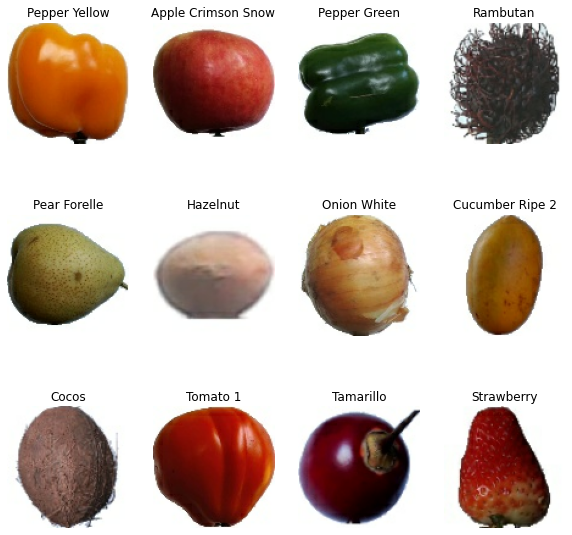

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
# def get_trian_val_test_split_ds(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
#     if shuffle:
#         ds.shuffle(shuffle_size, seed=99)
    
#     train_size = int(train_split*len(ds))
#     val_size = int(test_split*len(ds))
    
#     train_ds = ds.take(train_size)
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, val_ds, test_ds

In [9]:
def get_trian_val_test_split_ds(trn_ds,tst_ds, shuffle=True, shuffle_size=10000, reduced=False, reduce_size = 1.0):
    
    if shuffle:
        trn_ds.shuffle(shuffle_size, seed=99)
        tst_ds.shuffle(shuffle_size, seed=99)
    
    if reduced:
      reduced_trn_ds = trn_ds.take(int(reduce_size*len(trn_ds)))
      reduced_tst_ds = tst_ds.take(int(reduce_size*len(tst_ds)))

    val_size = int(0.5*len(reduced_tst_ds))
    
    train_ds = reduced_trn_ds
    val_ds = reduced_tst_ds.take(val_size)
    test_ds = reduced_tst_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_trian_val_test_split_ds(train_dataset, test_dataset, reduced=IS_REDUCE, reduce_size =REDUCE_SIZE)

In [11]:
len(train_ds)

1058

In [12]:
len(val_ds)

177

In [13]:
len(test_ds)

177

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 2


In [18]:
def get_compiled_model():
    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,

        layers.Conv2D(32, (3,3), activation='relu',padding = 'same', input_shape = input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3),padding = 'same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3),padding = 'same', activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # layers.Conv2D(128, (3,3),padding = 'same', activation='relu'),
        # layers.Conv2D(128, (3,3),padding = 'same', activation='relu'),
        # layers.MaxPooling2D((2,2)),
        # layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_class, activation='softmax')

    ])

    model.build(input_shape=input_shape)
    
    model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])
    
    return model

In [19]:
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

In [20]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
    
#     layers.Conv2D(64, (3,3), activation='relu',padding = 'same', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.25),
    
#     layers.Conv2D(32, (3,3),padding = 'same', activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.25),
    
#     layers.Conv2D(16, (3,3),padding = 'same', activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.25),
    
#     # layers.Conv2D(128, (3,3),padding = 'same', activation='relu'),
#     # layers.Conv2D(128, (3,3),padding = 'same', activation='relu'),
#     # layers.MaxPooling2D((2,2)),
#     # layers.Dropout(0.25),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_class, activation='softmax')
    
# ])

# model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 100, 100, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 100, 100, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 100, 100, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 50, 50, 32)          0         
_________________________________________________________________
dropout (Dropout)            (32, 50, 50, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 50, 50, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 25, 25, 64)         

In [22]:
# model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#              metrics=['accuracy'])

In [23]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
)

2023-01-13 04:06:49.076937: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/50


2023-01-13 04:07:03.626097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 89 of 1000
2023-01-13 04:07:13.558949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 180 of 1000
2023-01-13 04:07:23.552372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 272 of 1000
2023-01-13 04:07:33.605023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 367 of 1000
2023-01-13 04:07:43.631190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 461 of 1000
2023-01-13 04:07:53.575055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 556 of 1000
2023-01-13 04:08:03.558798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle bu

1057/1058 [============================>.] - ETA: 0s - loss: 2.5148 - accuracy: 0.3369

2023-01-13 04:09:20.752213: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}

2023-01-13 04:09:32.280665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 95 of 1000
2023-01-13 04:09:40.165428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


1058/1058 [==============================] - 172s 45ms/step - loss: 2.5140 - accuracy: 0.3370 - val_loss: 1.0296 - val_accuracy: 0.7226
Epoch 2/50
1058/1058 [==============================] - 23s 22ms/step - loss: 0.9095 - accuracy: 0.6990 - val_loss: 0.6838 - val_accuracy: 0.8024
Epoch 3/50
1058/1058 [==============================] - 24s 22ms/step - loss: 0.6341 - accuracy: 0.7832 - val_loss: 0.4438 - val_accuracy: 0.8831
Epoch 4/50
1058/1058 [==============================] - 24s 22ms/step - loss: 0.5345 - accuracy: 0.8166 - val_loss: 0.3382 - val_accuracy: 0.9101
Epoch 5/50
1058/1058 [==============================] - 24s 22ms/step - loss: 0.4629 - accuracy: 0.8411 - val_loss: 0.3959 - val_accuracy: 0.8828
Epoch 6/50
1058/1058 [==============================] - 23s 22ms/step - loss: 0.4119 - accuracy: 0.8565 - val_loss: 0.3147 - val_accuracy: 0.9193
Epoch 7/50
1058/1058 [==============================] - 23s 22ms/step - loss: 0.3682 - accuracy: 0.8726 - val_loss: 0.2600 - val_accur

In [24]:
scores = model.evaluate(test_ds)

2023-01-13 04:13:59.721820: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}

2023-01-13 04:14:09.894092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 52 of 1000
2023-01-13 04:14:19.900483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 152 of 1000


 23/177 [==>...........................] - ETA: 1s - loss: 0.3136 - accuracy: 0.9117 

2023-01-13 04:14:22.335280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


177/177 [==============================] - 24s 7ms/step - loss: 0.4021 - accuracy: 0.8863


In [26]:
model_structure = model.to_json()
f = Path('model_structure.json')
f.write_text(model_structure)

5373

In [27]:
model.save_weights('model_weights.h5')